# Introduction 


## How to use this notebook
This example runs Sima in locally based on input created in the [Create load case folders with unique Sima input](#loadcase_id) section. The code is only a pilot and only intended for testing. This Example requires Sima 4.4.

This notebook should be run in the following way:
1. [Initialize Workflow](#initialize), run this Python code once at every notebook start to set up basic settings. [Set up custom user parameters](#custom) section should be changed if you want to change workspace or switch between cloud and local run. 2. If you changed something in this section, remember to rerun  [Set up OneWorkflow client](#builder).
2. [Run analysis](#run) shall be run each time a new Sima analysis needs to be run.
If you rerun you may need to restart the notebook using the restart kernel button:


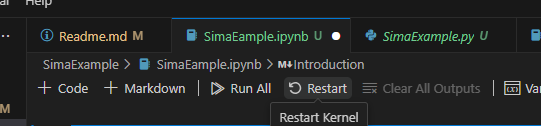



# Initialize workflow <a id='initialize'></a>
Run only once when notebook is opened.

## Set up custom user parameters <a id='custom'></a>
You need to set oneWorkflowTMPFolder to a folder that works for you. A short folder path  is recommended due to possible issues with Sima and long file names.

In [ ]:
from pathlib import Path
import os

oneWorkflowTMPFolder = r'C:\oneworkflowTmp' #due to possible issues with long file paths we prefer to have this folder at the root
if not os.path.exists(oneWorkflowTMPFolder):
    try:
        print("Trying to create tmp folder for one workflow local execution")
        os.mkdir(oneWorkflowTMPFolder)
        print(oneWorkflowTMPFolder + " created!\n")
    except:
        print("did not manage to create tmp folder for local execution. Check that you have privileges to create it or try to manually create it from the coomand line.")

# local workspace, all results will be put here after local or cloud runs
# location of common files for all analysis, has to be below workspacePath
root_folder = os.getcwd()
print(root_folder)
workspacePath = str(Path(root_folder, 'WorkspaceInplace'))
workspaceId = "SimaSimple"
loadcase_file = f"{workspacePath}\\test_cases_light.xlsx"
stask_file = "SimaTemplateLight.stask"
cloudRun = False
clean = True
notebook_root_folder = os.getcwd()
load_case_folder = os.path.join(workspacePath,"LoadCases")

## Set up OneWorkflow client <a id='builder'></a>
Run only once workbook is started or if some parameters above are changed.

In [ ]:
from dnv.oneworkflow.utils.workunit_extension import *
from dnv.oneworkflow.utils import *
import shutil

workflow_client = one_workflow_client(workspace_id = workspaceId, cloud_run = cloudRun, workspace_path = workspacePath, local_workflow_runtime_temp_folder_path = oneWorkflowTMPFolder,inplace_execution=True,
                                     local_workflow_runtime_temp_folders_cleanup=False,platform=Platform.WINDOWS, max_cores=5,environment=Environment.Testing,pool_id="SesamWorkflow_Windows_Standard_A2_v2")


# Run Sima analysis <a id='run'></a>
This code will fetch data from the blob storage created in the step above, and run all the job tasks. The code will wait for all tasks to complete before downloading the results.

In [ ]:
from dnv.sesam.commands import SimaCommand
import pandas as pd
from dnv.onecompute.flowmodel import SchedulingOptions, FailureStrategy
"""Tests SIMA and Python commands"""
commands_info = []

if clean:
    shutil.rmtree(load_case_folder, ignore_errors=True)
df_cases = pd.read_excel(loadcase_file, index_col=0)

for loadcase_folder_name, case in df_cases.iterrows():
    sima_cmd = SimaCommand().create_sima_command(task_name="WorkflowTask",workflow_name="ExampleWorkflow",sima_case_data=case.to_dict(),stask_filename=stask_file,stask_foldername=workflow_client.common_directory)
    commands_info.append(CommandInfo(commands=[sima_cmd],load_case_foldername=loadcase_folder_name))
print("Running commands in parallel")
#enable_file_transfer_progress_reporting(workflow_client)
await run_managed_commands_in_parallel_async(
            client=workflow_client,
            scheduling_options=SchedulingOptions(failure_strategy=FailureStrategy.ContinueOnError),
            commands_info=commands_info,
            files_to_download_from_blob_to_client=FileTransferOptions(max_size="11124MB",patterns=["**/*.log","**/*.txt", "**/*.lis", "**/*.MLG", "**/*.MLG","**/*.CSV"]),
            enable_common_files_copy_to_load_cases=True,
)
import time
time.sleep(5)


# Post processing  <a id='postprocessing'></a>

In [ ]:
import re
def get_sima_execution_time(folder):
    try:
        pattern = r"Total\s+([\d.]+)\n"
        file_path = os.path.join(folder, "prs-sima.lis")
        with open(file_path, "r") as file:
            content = file.read()
         # Extract the total time using regular expressions
        match = re.search(pattern, content)
        if match:
            return float(match.group(1))
    except:
        print(f"Error while trying to read {file_path}")
        return None
        

# Specify the file path
cases = []
timings= []
for folder in os.listdir(load_case_folder):
    if os.path.isdir(load_case_folder):
        time = get_sima_execution_time(os.path.join(load_case_folder, folder))
        timings.append(time)
        cases.append(folder)
import matplotlib.pyplot as plt
plt.plot(cases, timings,'-*')
plt.xlabel('Load case')
plt.ylabel('Execution time [s]')
